## Задача 1. ALS vs градиентный спуск

1. Сгенерируйте случайную малоранговую матрицу $X$ размером $1000 \times 1000$ и ранга $100$
2. Решите следующую задачу оптимизации с помощью градиентного спуска по параметрам $U, V$ и с помощью метода ALS (Alternating Least Squares)
$$
\min_{U, V} \| X - U^{\top}V\|^2_F.
$$
Метод ALS заключается в следующем
    - задаётся начальное приближение $U_0$ и $V_0$
    - фиксируется $U$ и ищется минимум по переменной $V$ соответственно
    - фиксируется найденное значение $V$ и оптимизируется значение $U$
    - и так далее до сходимости
3. Сравните сходимость ALS и градиентного спуска для этой задачи
4. Исследуйте зависимость от начального приближения и объясните её
5. Рассмотрите различные способы выбора шага в градиентном спуске и сделайте вывод о применимости каждого из них

In [3]:
import numpy as np
from numpy.linalg import norm

class InitialData:
    def __init__(self, u0 = None, v0 = None):
        self.u0 = u0
        self.v0 = v0
        
    def randomize(self, size, rank):
        self.u0 = np.random.rand(int(rank / 2), size)
        self.v0 = np.random.rand(int(rank / 2), size)
        
        
class SolverSettings:
    def __init__(self, stepU, stepV, dynamicStep = False, stepUpdateWith = 0.95, stepEps = 1e-1, eps = 1e-4, maxIterations = 500):
        self.stepU = stepU
        self.stepV = stepV
        self.dynamicStep = dynamicStep
        self.stepUpdateWith = stepUpdateWith
        self.stepEps = stepEps
        self.eps = eps
        self.maxIterations = maxIterations
        
class Function:    
    def generate(self, X):
        self._F = self.generateFunction(X)
        self._gradientU = self.generateGradientU(X)
        self._gradientUFixed = self.generateGradientUFixed(X)
        self._gradientV = self.generateGradientV(X)
        self._gradientVFixed = self.generateGradientVFixed(X)
    
    def generateFunction(self, X):
        return lambda u, v: np.linalg.norm(X - u.T.dot(v), ord='fro')

    def generateGradientU(self, X):
        return lambda u, v: -2.0 * v.dot(X.T - v.T.dot(u))

    def generateGradientUFixed(self, X):
        return lambda v: np.linalg.inv(v.dot(v.T)).dot(v.dot(X.T))  
    
    def generateGradientV(self, X):
        return lambda u, v: -2.0 * u.dot(X - u.T.dot(v))
    
    def generateGradientVFixed(self, X):
        return lambda u: np.linalg.inv(u.dot(u.T)).dot(u.dot(X))
        
    def apply(self, u, v):
        return self._F(u, v)
    
    def gradientU(self, u, v):
        return self._gradientU(u, v)
    
    def gradientUFixed(self, v):
        return self._gradientUFixed(v)
    
    def gradientV(self, u, v):
        return self._gradientV(u, v)
    
    def gradientVFixed(self, u):
        return self._gradientVFixed(u)
    

In [33]:
class GradientDescentSolver:
    u = None
    v = None
    points = None
    iters = None
    errors = None
    
    def __init__(self, f, settings):
        self.f = f
        self.settings = settings
        
    def solve(self, initial):
        u = initial.u0
        v = initial.v0
        points = [self.f.apply(u, v)]
        errorU = 1.0
        errorV = 1.0
        stepU = self.settings.stepU
        stepV = self.settings.stepV
        eps = self.settings.eps
        currentIteration = 0
        maxIterations = self.settings.maxIterations
        errors = []
        while errorU > eps and errorV > eps and currentIteration < maxIterations:
            previousU = u
            previousV = v
            
            gradientU = self.f.gradientU(u, v)
            previousFUV = self.f.apply(u, v)
            u = u - stepU * gradientU
            if self.settings.dynamicStep:
                FUV = self.f.apply(u, v)
                error = norm(gradientU, 2)
                while FUV > previousFUV - self.settings.stepEps * stepU * (error ** 2):
                    stepU = stepU * self.settings.stepUpdateWith
                    FUV = self.f.apply(previousU - stepU * gradientU, v)
                u = previousU - stepU * gradientU
                
            gradientV = self.f.gradientV(u, v)
            previousFUV = self.f.apply(u, v)
            v = v - stepV * gradientV
            if (self.settings.dynamicStep):
                FUV = self.f.apply(u, v)
                error = norm(gradientV, 2)
                while FUV > previousFUV - self.settings.stepEps * stepV * (error ** 2):
                    stepV = stepV * self.settings.stepUpdateWith
                    FUV = self.f.apply(u, previousV - stepV * gradientV)
                v = previousV - stepV * gradientV
                
            points.append(self.f.apply(u, v))
            
            errorU = norm(self.f.gradientU(u, v), 2)
            errorV = norm(self.f.gradientV(u, v), 2)
            errors.append(errorU)
            currentIteration = currentIteration + 1
        self.u = u
        self.v = v
        self.points = points
        self.iters = currentIteration
        self.errors = errors
        
    def getPlotPoints(self):
        return self.points
    
    def getIterationsNumber(self):
        return self.iters
    
    def getErrorPoints(self):
        return self.errors

In [5]:
class ALSSolver:
    u = None
    v = None
    points = None
    iters = None
    
    def __init__(self, f, settings):
        self.f = f
        self.settings = settings
        
    def solve(self, initial):
        u = initial.u0
        v = initial.v0
        points = [self.f.apply(u, v)]
        errorU = 1.0
        errorV = 1.0
        eps = self.settings.eps
        currentIteration = 0
        maxIterations = self.settings.maxIterations
        while errorU > eps and errorV > eps and currentIteration < maxIterations:
            previousU = u
            previousV = v
            
            u = self.f.gradientUFixed(v)
            v = self.f.gradientVFixed(u)
            points.append(self.f.apply(u, v))
            errorU = norm(previousU - u, 2) / norm(u, 2)
            errorV = norm(previousV - v, 2) / norm(v, 2)
            currentIteration += 1
            
        self.u = u
        self.v = v
        self.points = points
        self.iters = currentIteration
        
    def getPlotPoints(self):
        return self.points
    
    def getIterationsNumber(self):
        return self.iters

In [6]:
def generateLowRankMatrix(size, rank):
    matrix = np.zeros((size, size))
    for i in range(rank):
        a = np.random.rand(size, 1)
        b = np.random.rand(1, size)
        matrix = matrix + a.dot(b)
    return matrix

Генерация случайной малоранговой матрицы и решении задачи оптимизации с помощью градиентного спуска по параметрам $U$ и $V$, и с помощью метода ALS

Тестирование происходит для матриц одного и тоже размера, но разного ранга

Как видно из графиков, хуже всех сходится метод градиентного спуска с фиксированным шагом, лучше всех всегда сходится метод ALS

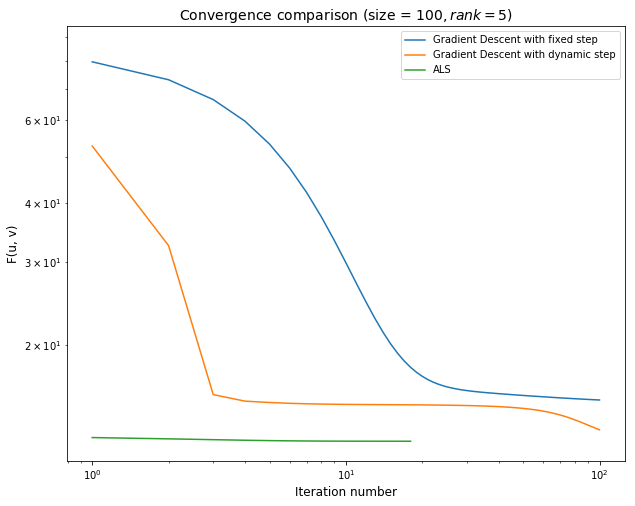

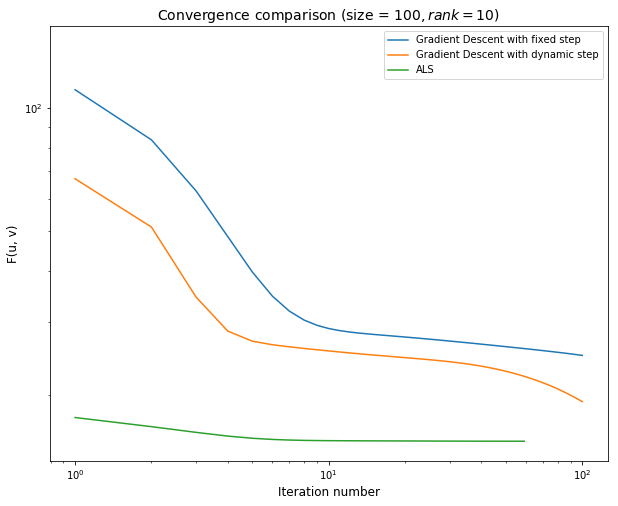

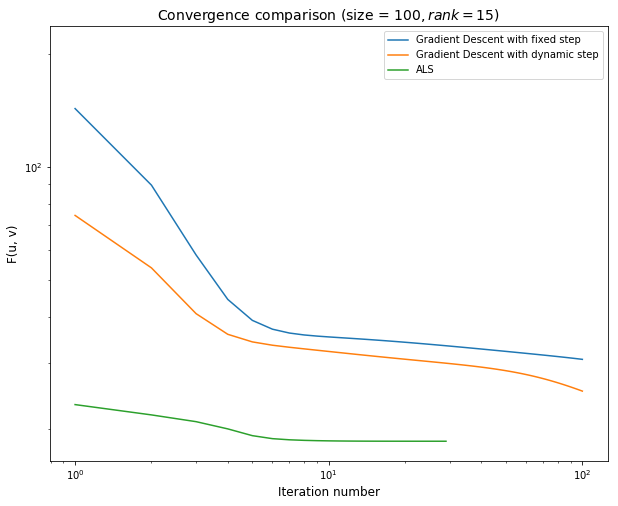

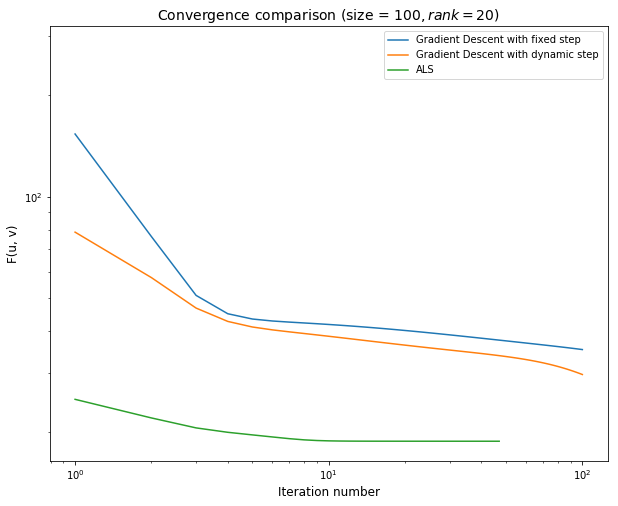

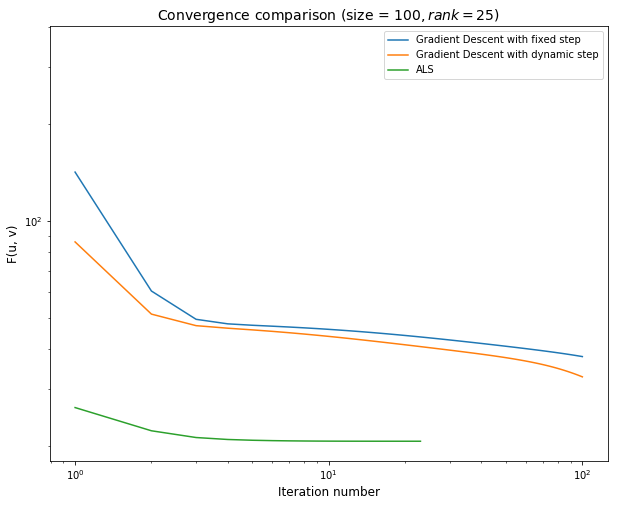

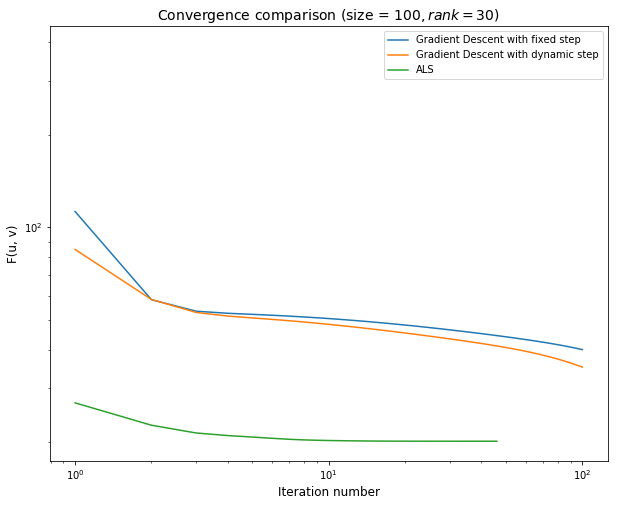

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

size = 100
ranks = [5, 10, 15, 20, 25, 30]

for rank in ranks:
    matrix = generateLowRankMatrix(size, rank)
    function = Function()
    function.generate(matrix)

    initial = InitialData()
    initial.randomize(size, rank)

    settingsFixed = SolverSettings(5e-4, 5e-4, maxIterations = 100)
    settingsDynamic = SolverSettings(1.0, 1.0, True, 0.95, 1e-3, maxIterations = 100)
    
    solverFixed = GradientDescentSolver(function, settingsFixed)
    solverFixed.solve(initial)
    solverDynamic = GradientDescentSolver(function, settingsDynamic)
    solverDynamic.solve(initial)
    solverALS = ALSSolver(function, settingsFixed)
    solverALS.solve(initial)
    # print("Rank %d completed" % rank)
    
    plt.figure(figsize=(10, 8))
    plt.plot(solverFixed.getPlotPoints(), label="Gradient Descent with fixed step")
    plt.plot(solverDynamic.getPlotPoints(), label="Gradient Descent with dynamic step")
    plt.plot(solverALS.getPlotPoints(), label="ALS")
    plt.title("Convergence comparison (size = ${0}, rank = ${1})".format(size, rank), fontsize=14)
    plt.xlabel("Iteration number", fontsize=12)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("F(u, v)", fontsize=12)
    _ = plt.legend()

In [8]:
print("Исследуйте зависимость от начального приближения и объясните её")

Исследуйте зависимость от начального приближения и объясните её


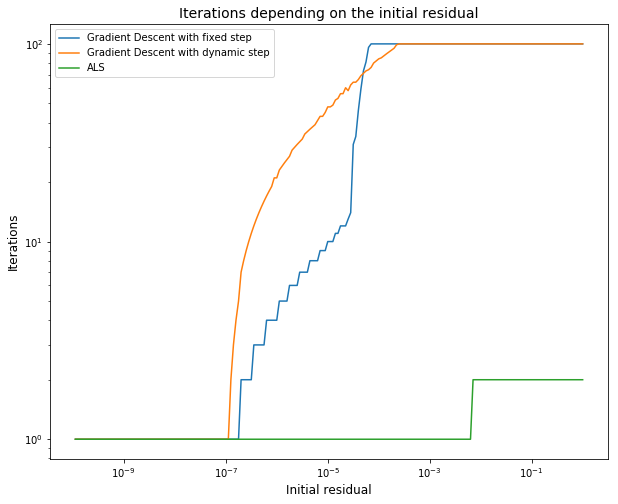

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

size = 100
rank = 10

XU = np.random.rand(rank, size)
XV = np.random.rand(rank, size)
X = XU.T.dot(XV)

function = Function()
function.generate(X)

errPoints = []
fixedIters = []
dynamicIters = []
alsIters = []
for i in np.arange(0.0, 10.0, 0.05):
    u0 = np.random.rand(rank, size)
    v0 = np.random.rand(rank, size)

    u0 = XU + u0 * (10.0**(-i) / norm(u0, 2))
    v0 = XV + v0 * (10.0**(-i) / norm(v0, 2))
    errPoints.append(10.0**(-i))
    
    initial = InitialData(u0, v0)

    settingsFixed = SolverSettings(5e-4, 5e-4, maxIterations = 100)
    settingsDynamic = SolverSettings(1.0, 1.0, True, 0.95, 1e-3, maxIterations = 100)
    
    solverFixed = GradientDescentSolver(function, settingsFixed)
    solverFixed.solve(initial)
    fixedIters.append(solverFixed.getIterationsNumber())
    
    solverDynamic = GradientDescentSolver(function, settingsDynamic)
    solverDynamic.solve(initial)
    dynamicIters.append(solverDynamic.getIterationsNumber())
    
    solverALS = ALSSolver(function, settingsFixed)
    solverALS.solve(initial)
    alsIters.append(solverALS.getIterationsNumber())
    # print("Rank %d completed" % rank)

plt.figure(figsize=(10, 8))
plt.plot(errPoints, fixedIters, label="Gradient Descent with fixed step")
plt.plot(errPoints, dynamicIters, label="Gradient Descent with dynamic step")
plt.plot(errPoints, alsIters, label="ALS")
plt.title("Iterations depending on the initial residual", fontsize=14)
plt.xlabel("Initial residual", fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Iterations", fontsize=12)
_ = plt.legend()
    

Из графика понятно, что чем ближе начальное приближение, тем быстрее сходится метод градиентного спуска

Причем градиентного спуска сходиться чуть хуже , потому что начальный шаг ставиться довольно большим и ему требуется больше времени, чтобы уменьшить этот шаг и сойтись к нужному значению. В то время при фиксированном шаге (и достаточно маленьком, в данном случае порядка $1e^{-5}$), очевидно будет сходиться быстрее, так как мы уже достаточно близко к ответу

Метод ALS сходиться достаточно быстро и не сильно зависит от начального приближения, так как функция, которую мы оптимизируем, является выпуклой


In [10]:
print("Рассмотрите различные способы выбора шага в градиентном спуске и сделайте вывод о применимости каждого из них")

Рассмотрите различные способы выбора шага в градиентном спуске и сделайте вывод о применимости каждого из них


In [11]:
size = 100
rank = 2

XU = np.random.rand(rank, size)
XV = np.random.rand(rank, size)
X = XU.T.dot(XV)

function = Function()
function.generate(X)

u0 = np.random.rand(rank, size)
v0 = np.random.rand(rank, size)

u0 = XU + u0 * (10.0**(-6) / norm(u0, 2))
v0 = XV + v0 * (10.0**(-6) / norm(v0, 2))

initial = InitialData(u0, v0)

sArray = np.arange(-5.0, 1.0, 0.1)
pFixed = []
pDynamic = []
steps = []
for s in sArray:
    step = 10 ** s
    steps.append(step)
    settingsFixed = SolverSettings(step, step, maxIterations = 1000)
    solverFixed = GradientDescentSolver(function, settingsFixed)
    solverFixed.solve(initial)
    
    settingsDynamic = SolverSettings(step, step, True, 0.95, 1e-3, maxIterations = 100)
    solverDynamic = GradientDescentSolver(function, settingsDynamic)
    solverDynamic.solve(initial)
    dynamicIters.append(solverDynamic.getIterationsNumber())
    
    pointsFixed = solverFixed.getPlotPoints()
    if (pointsFixed[len(pointsFixed) - 1] < 1.0):
        pFixed.append(1.0)
    else:
        pFixed.append(0.0)    
        
    pointsDynamic = solverDynamic.getPlotPoints()
    if (pointsDynamic[len(pointsDynamic) - 1] < 1.0):
        pDynamic.append(1.0)
    else:
        pDynamic.append(0.0) 
    #print(step, solverFixed.getIterationsNumber())

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in multiply


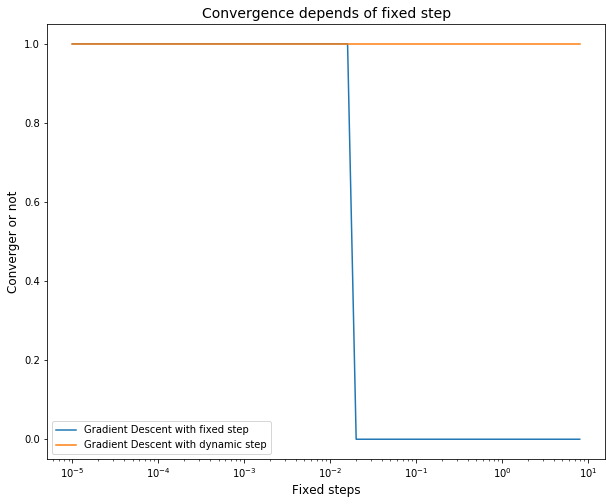

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(steps, pFixed, label="Gradient Descent with fixed step")
plt.plot(steps, pDynamic, label="Gradient Descent with dynamic step")
plt.title("Convergence depends of fixed step", fontsize=14)
plt.xlabel("Fixed steps", fontsize=12)
plt.xscale("log")
plt.ylabel("Converger or not", fontsize=12)
_ = plt.legend()

Как можно заметить на графике, градиентный спуск с фиксированным шагом перестает сходиться при некотором критическом значениии, в то время как градиентный спуск с динамическим шагом продолжает сходиться 

Дополнительно в первой задаче рассмотрите 3 варианта размеров для матриц U и V:
* Вы точно знаете правильный ранг = 100
* Вы недооценили ранг, то есть выберите любое натуральное число от 1 до 100
* Вы переоценили ранг, то есть выберите любое натуральное число от 100 до 1000

In [45]:
size = 100
rank = 10

XU = np.random.rand(rank, size)
XV = np.random.rand(rank, size)
X = XU.T.dot(XV)

function = Function()
function.generate(X)

rank1 = 10
rank2 = np.random.randint(10)
rank3 = np.random.randint(90) + 10

u1 = np.random.rand(rank1, size)
v1 = np.random.rand(rank1, size)

u2 = np.random.rand(rank2, size)
v2 = np.random.rand(rank2, size)

u3 = np.random.rand(rank3, size)
v3 = np.random.rand(rank3, size)

initial1 = InitialData(u1, v1)
initial2 = InitialData(u2, v2)
initial3 = InitialData(u3, v3)

settingsFixed = SolverSettings(5e-4, 5e-4, maxIterations = 100)
settingsDynamic = SolverSettings(1.0, 1.0, True, 0.95, 1e-3, maxIterations = 100)

solverFixed = GradientDescentSolver(function, settingsFixed)

In [47]:
solverFixed.solve(initial3)
print(solverFixed.getPlotPoints())

[1929.0261517251108, 1895.4388248502505, 4948.139154446395, 8514398.7416839506, 8.618569127912146e+25, 4.8134691596298418e+136, inf]
